In [1]:
# Import libraries
import numpy as np
import pandas as pd
from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, RobustScaler
import pickle
import joblib
import matplotlib.pyplot as plt

In [2]:
# load dataset
def load_data(file_name, sheet=0):
    return pd.read_excel(file_name, sheet_name=sheet)

In [3]:
# datasets
transact = load_data(file_name = 'KPMG_VI_New_raw_data.xlsx',sheet=0)
customer_demo = load_data(file_name = 'KPMG_VI_New_raw_data.xlsx',sheet=1)
customer_address = load_data(file_name = 'KPMG_VI_New_raw_data.xlsx',sheet=2)

transact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
transaction_id             20000 non-null int64
product_id                 20000 non-null int64
customer_id                20000 non-null int64
transaction_date           20000 non-null datetime64[ns]
online_order               19640 non-null float64
order_status               20000 non-null object
brand                      19803 non-null object
product_line               19803 non-null object
product_class              19803 non-null object
product_size               19803 non-null object
list_price                 20000 non-null float64
standard_cost              19803 non-null float64
product_first_sold_date    19802 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(3), object(5)
memory usage: 2.0+ MB


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

NameError: name 'X' is not defined

In [5]:
# copy datasets
transact_copy = transact.copy()
customer_demo_copy = customer_demo.copy()
customer_address_copy = customer_address.copy()

In [6]:
transact_appr = transact_copy[transact_copy['order_status']=='Approved']
transact_appr.reset_index(inplace=True, drop=True)
transact_appr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19821 entries, 0 to 19820
Data columns (total 13 columns):
transaction_id             19821 non-null int64
product_id                 19821 non-null int64
customer_id                19821 non-null int64
transaction_date           19821 non-null datetime64[ns]
online_order               19467 non-null float64
order_status               19821 non-null object
brand                      19625 non-null object
product_line               19625 non-null object
product_class              19625 non-null object
product_size               19625 non-null object
list_price                 19821 non-null float64
standard_cost              19625 non-null float64
product_first_sold_date    19624 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(3), object(5)
memory usage: 2.0+ MB


In [7]:
transact_appr.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,94,86,1,2017-12-23,0.0,Approved,OHM Cycles,Standard,medium,medium,235.63,125.07,38482.0
1,3765,38,1,2017-04-06,1.0,Approved,Solex,Standard,medium,medium,1577.53,826.51,39526.0
2,5157,47,1,2017-05-11,1.0,Approved,Trek Bicycles,Road,low,small,1720.70,1531.42,37823.0
3,9785,72,1,2017-01-05,0.0,Approved,Norco Bicycles,Standard,medium,medium,360.40,270.30,37873.0
4,13424,2,1,2017-02-21,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,38573.0


In [8]:
# transact_appr.groupby(by='customer_id')['standard_cost'].sum()

def get_profit(df):
    ID = df.groupby(by='customer_id')
    profit = ID['list_price'].sum() - ID['standard_cost'].sum()
    
    return profit

In [9]:
profit_df = pd.DataFrame(get_profit(transact_appr), columns=['profit'])
profit_df.reset_index(inplace=True)
profit_df.head()

,customer_id,profit
0,1,3018.09
1,2,2226.26
2,3,3362.81
3,4,220.57
4,5,2394.94


In [10]:
customer_data = pd.concat([customer_address_copy,customer_demo_copy.drop('customer_id', axis=1)], axis=1)
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 17 columns):
customer_id                            4000 non-null int64
address                                4000 non-null object
postcode                               4000 non-null int64
state                                  4000 non-null object
country                                4000 non-null object
property_valuation                     4000 non-null int64
first_name                             4000 non-null object
last_name                              3875 non-null object
gender                                 4000 non-null object
past_3_years_bike_related_purchases    4000 non-null int64
DOB                                    3913 non-null datetime64[ns]
job_title                              3494 non-null object
job_industry_category                  3344 non-null object
wealth_segment                         4000 non-null object
deceased_indicator                     4000 non-n

In [11]:
data = pd.merge(profit_df, customer_data, how='left', on='customer_id')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3493 entries, 0 to 3492
Data columns (total 18 columns):
customer_id                            3493 non-null int64
profit                                 3493 non-null float64
address                                3492 non-null object
postcode                               3492 non-null float64
state                                  3492 non-null object
country                                3492 non-null object
property_valuation                     3492 non-null float64
first_name                             3492 non-null object
last_name                              3380 non-null object
gender                                 3492 non-null object
past_3_years_bike_related_purchases    3492 non-null float64
DOB                                    3416 non-null datetime64[ns]
job_title                              3069 non-null object
job_industry_category                  2931 non-null object
wealth_segment                         349

In [14]:
final_data = data[['profit', 'state', 'property_valuation', 'gender', 'owns_car', 'past_3_years_bike_related_purchases', 'job_industry_category',\
                  'wealth_segment', 'tenure']]
final_data.head()

,profit,state,property_valuation,gender,owns_car,past_3_years_bike_related_purchases,job_industry_category,wealth_segment,tenure
0,3018.09,New South Wales,10.0,F,Yes,93.0,Health,Mass Customer,11.0
1,2226.26,New South Wales,10.0,Male,Yes,81.0,Financial Services,Mass Customer,16.0
2,3362.81,QLD,9.0,Male,Yes,61.0,Property,Mass Customer,15.0
3,220.57,New South Wales,4.0,Male,No,33.0,IT,Mass Customer,7.0
4,2394.94,VIC,9.0,Female,Yes,56.0,NaN,Affluent Customer,8.0


In [15]:
final_data['gender'].replace({'M':'Male', 'Femal':'Female', 'F':'Female', '247':'Female', 'U':'Female'}, inplace=True)

final_data['state'].replace({'Victoria' : 'VIC', 'New South Wales' : 'NSW'}, inplace=True)

C:\Users\iDAFAdmin\Anaconda3\lib\site-packages\pandas\core\generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [16]:
# fill missing values

final_data['state'].fillna(final_data['state'].mode()[0], inplace=True)
final_data['property_valuation'].fillna(final_data.property_valuation.mean(), inplace=True)
final_data['gender'].fillna(final_data['gender'].mode()[0], inplace=True)
final_data['past_3_years_bike_related_purchases'].fillna(final_data['past_3_years_bike_related_purchases'].mean(),\
                                                         inplace=True)
final_data['wealth_segment'].fillna(final_data['wealth_segment'].mode()[0], inplace=True)
final_data['owns_car'].fillna(final_data['owns_car'].mode()[0], inplace=True)
final_data['tenure'].fillna(final_data['tenure'].mean(), inplace=True)
final_data['job_industry_category'].fillna(final_data['job_industry_category'].mode()[0], inplace=True)

C:\Users\iDAFAdmin\Anaconda3\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [17]:
state_mode = final_data['state'].mode()[0], 
pv_mean = final_data.property_valuation.mean(), 
gender_mode = final_data['gender'].mode()[0]
pybrp = final_data['past_3_years_bike_related_purchases'].mode()[0]
wealth_seg = final_data['wealth_segment'].mode()[0]
owns_car = final_data['owns_car'].mode()[0]
ten = final_data['tenure'].mean()
jic = final_data['job_industry_category'].mode()[0]

In [18]:
final_data['job_industry_category'].mode()

0    Manufacturing
dtype: object

In [19]:
# replace_vals = {'state':1, 'property_valuation':7.52, 'gender':1, 'past_3_years_bike_related_purchases':48.81, \
#                'wealth_segment': 2, 'owns_car':1, 'tenure':10.68, 'job_industry_category':4}

In [20]:
final_data.isnull().sum()

profit                                 0
state                                  0
property_valuation                     0
gender                                 0
owns_car                               0
past_3_years_bike_related_purchases    0
job_industry_category                  0
wealth_segment                         0
tenure                                 0
dtype: int64

In [21]:
# label encoding
final_data['gender'].replace({'Female' : 1, 'Male' : 2}, inplace=True)
final_data['job_industry_category'].replace({'Entertainment' : 1, 'Telecommunications' : 2, 'IT' : 3, 'Manufacturing' : 4, 'Financial Services' : 5, 'Retail' : 6, 'Health' : 7, 'Property' : 8, 'Argiculture' : 9}, inplace=True)
final_data['state'].replace({'NSW' : 1, 'VIC' : 2, 'QLD' : 3}, inplace=True)
final_data['wealth_segment'].replace({'Affluent Customer' : 1, 'Mass Customer' : 2, 'High Net Worth' : 3}, inplace=True)
final_data['owns_car'].replace({'Yes' : 1, 'No' : 2}, inplace=True)

In [22]:
final_data.head()

,profit,state,property_valuation,gender,owns_car,past_3_years_bike_related_purchases,job_industry_category,wealth_segment,tenure
0,3018.09,1,10.0,1,1,93.0,7,2,11.0
1,2226.26,1,10.0,2,1,81.0,5,2,16.0
2,3362.81,3,9.0,2,1,61.0,8,2,15.0
3,220.57,1,4.0,2,2,33.0,3,2,7.0
4,2394.94,2,9.0,1,1,56.0,4,1,8.0


In [158]:
# final_data.to_csv('training_data_label_encoded.csv', index=False)

In [98]:
# def get_data(excel_sheet, sheet: int=0, file: bool=True):
#     features = ['state', 'country', 'property_valuation', 'gender', 'owns_car', 'past_3_years_bike_related_purchases', 'job_industry_category',\
#                   'wealth_segment', 'tenure']
#     data = load_data(file_name=excel_sheet, sheet=sheet)
#     data_new = data[features]
#     return data_new

In [23]:
final_data.head()

,profit,state,property_valuation,gender,owns_car,past_3_years_bike_related_purchases,job_industry_category,wealth_segment,tenure
0,3018.09,1,10.0,1,1,93.0,7,2,11.0
1,2226.26,1,10.0,2,1,81.0,5,2,16.0
2,3362.81,3,9.0,2,1,61.0,8,2,15.0
3,220.57,1,4.0,2,2,33.0,3,2,7.0
4,2394.94,2,9.0,1,1,56.0,4,1,8.0


In [24]:
# states = pd.get_dummies(final_data['state'],drop_first=True)
# countrys = pd.get_dummies(final_data['country'],drop_first=True)
# job_industry_cats = pd.get_dummies(final_data['job_industry_category'],drop_first=True)
# gender = pd.get_dummies(final_data['gender'],drop_first=True)
# wealth_segs = pd.get_dummies(final_data['wealth_segment'],drop_first=True)
# car_owns = pd.get_dummies(final_data['owns_car'],drop_first=True)


# data = pd.concat([states, countrys, job_industry_cats, gender, wealth_segs, car_owns], axis=1)
# final_data_2 = pd.concat([final_data.drop(['state', 'country', 'job_industry_category', 'gender', \
#                                            'wealth_segment', 'owns_car'], axis=1), data], axis=1)

# final_data_2.head()

In [67]:
X = final_data.drop('profit', axis=1)
y = final_data['profit']

In [68]:
scaler  = StandardScaler()
X = scaler.fit_transform(X)

with open('scaler.pickle', 'wb') as f:
    pickle.dump(scaler, f)

In [74]:
X

array([[-8.44552532e-01,  8.79402544e-01, -9.48912670e-01, ...,
         1.12221145e+00, -1.82300416e-02,  5.62295675e-02],
       [-8.44552532e-01,  8.79402544e-01,  1.05383776e+00, ...,
        -2.26146583e-02, -1.82300416e-02,  9.47139599e-01],
       [ 1.64702010e+00,  5.25329711e-01,  1.05383776e+00, ...,
         1.69462450e+00, -1.82300416e-02,  7.68957593e-01],
       ...,
       [-8.44552532e-01,  1.23347538e+00,  1.05383776e+00, ...,
        -5.95027712e-01, -1.82300416e-02, -6.56498457e-01],
       [ 4.01233783e-01,  8.79402544e-01, -9.48912670e-01, ...,
        -2.31226687e+00, -1.43328638e+00,  1.12532161e+00],
       [-8.44552532e-01,  0.00000000e+00, -9.48912670e-01, ...,
        -5.95027712e-01, -1.82300416e-02,  3.16514825e-16]])

In [63]:
# y_scaler = StandardScaler()
# y = y_scaler.fit_transform(np.array(y).reshape(-1,1))

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [70]:
lasso = Lasso()
ridge = Ridge()
elastic_net = ElasticNet()

In [71]:
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)
print(f'Lasso model has an RMSE: {sqrt(mean_squared_error(y_test, lasso_pred))}')

ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)
print(f'Ridge model has an RMSE: {sqrt(mean_squared_error(y_test, ridge_pred))}')

elastic_net.fit(X_train, y_train)
elasticNet_pred = elastic_net.predict(X_test)
print(f'Elastic Net model has an RMSE: {sqrt(mean_squared_error(y_test, elasticNet_pred))}')

Lasso model has an RMSE: 1829.289405286639
Ridge model has an RMSE: 1829.3564262380673
Elastic Net model has an RMSE: 1827.6301324837477


In [73]:
joblib.dump(lasso, 'Lasso_model.pkl')

['Lasso_model.pkl']

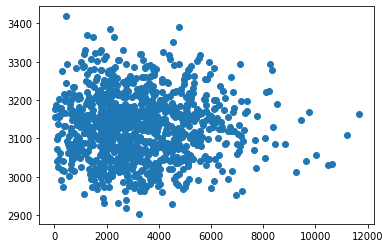

In [80]:
plt.scatter(y_test, lasso_pred)